In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
np.random.seed(42)

In [3]:
from environments import EnvironmentModel1 as Environment
from environments import translate_action_model1 as translate_action
from environments import reward_scaler_model1 as reward_scaler
from environments import STATES_MU1, STATES_SIGMA1
from environments.model1 import scale_states

In [4]:
from agents import DQIterationAgent as Agent

In [5]:
size_multiplier = 0.7
FIGSIZE = (14*size_multiplier, 8*size_multiplier)

In [6]:
agent = Agent(0.005, 0.99 ,16, 8, 5, 4, STATES_MU1, STATES_SIGMA1)

In [7]:
agent.load_model("models//dqfi_model")

In [10]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)

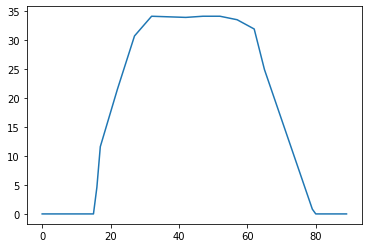

In [11]:
plt.plot(women_hours)

In [128]:
parameters = {
    'beta_L' : 3,
    'sigma_epsilon' : 0.1, 
    'S_min': 120.0,
    'alpha': 4.609,
    'eta_G': 0.164,
    'eta_G_sq' : 0.015,
    'delta': 0.209,
    'sigma_epsilon': 15.11,
    'omega': 3.5,
}

EPISODES = 30

In [137]:
def simulate_observations(parameters, n_episodes):

    env = Environment(**parameters)

    rewards_history, action_history = list(), list()
    agent.epsilon=0.0
    agent.q_scaler.mu = 0.068
    agent.q_scaler.sigma = 0.16


    for e in range(n_episodes):
        env.reset()
        state = env.states
        for time in range(18, 500):
            action, q_vals = agent.act(state)
            _action = translate_action(action)
            next_state, reward, done, _ = env.step(_action)
            scaled_reward = (reward - 24 ) / 5


            rewards_history.append([reward, e, time])
            action_history.append([_action, e, time])

            state = next_state
            if done:
                #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, np.mean(rewards_history), agent.epsilon))
                break

    df_DQAgent = pd.DataFrame(rewards_history, columns=['rewards', 'episode', 'Q'])
    df_DQAgent_action = pd.DataFrame(action_history, columns=['actions', 'episode', 'Q'])
    
    return df_DQAgent, df_DQAgent_action


def get_simulated_mean(df_action):
    sim_avg_actions = df_action.drop('episode',axis=1).loc[df_action['actions'] > 0].groupby('Q').mean()

    sim_vals = np.zeros(shape=90)
    sim_avg_actions
    for ix in range(len(sim_vals)):
        obs = sim_avg_actions.loc[sim_avg_actions.index == ix]
        if len(obs) == 1:

            sim_vals[ix] = float(obs['actions'])

    return sim_vals

def trim_obs(array):
    return array[18:61]

def calc_loss(true_vals, sim_vals):
    return np.mean((true_vals - sim_vals)**2)

In [161]:
def objective(x):
    print('\n new iteration')

    np.random.seed(10)
    
    n_episodes = 300
    
    beta_L = x
    parameters = {
        'beta_L' : beta_L,
        'sigma_epsilon' : 0.1, 
        'S_min': 120.0,
        'alpha': 4.609,
        'eta_G': 0.164,
        'eta_G_sq' : 0.015,
        'delta': 0.209,
        'sigma_epsilon': 15.11,
        'omega': 3.5,
    }
    
    df, df_action = simulate_observations(parameters, n_episodes)
    sim_vals = get_simulated_mean(df_action)
    true_vals, sim_vals = trim_obs(women_hours), trim_obs(sim_vals)
    mse = calc_loss(true_vals, sim_vals)
    print('beta L:', beta_L, ' mse:', mse)
    return mse

In [162]:
beta_Ls, mses = np.linspace(0.0, 8.0), list()

for beta_L in beta_Ls:
    mse = objective(beta_L)
    mses.append(mse)



 new iteration
beta L: 0.0  mse: 203.74626976744185

 new iteration
beta L: 0.16326530612244897  mse: 194.8272

 new iteration
beta L: 0.32653061224489793  mse: 190.37696744186047

 new iteration
beta L: 0.4897959183673469  mse: 182.32487441860465

 new iteration
beta L: 0.6530612244897959  mse: 184.71743255813956

 new iteration
beta L: 0.8163265306122448  mse: 184.71743255813956

 new iteration
beta L: 0.9795918367346939  mse: 188.3416186046512

 new iteration
beta L: 1.1428571428571428  mse: 192.7918511627907

 new iteration
beta L: 1.3061224489795917  mse: 206.22068837209304

 new iteration
beta L: 1.4693877551020407  mse: 216.50906046511625

 new iteration
beta L: 1.6326530612244896  mse: 225.614176744186

 new iteration
beta L: 1.7959183673469385  mse: 225.614176744186

 new iteration
beta L: 1.9591836734693877  mse: 214.33045581395348

 new iteration
beta L: 2.1224489795918364  mse: 222.79557209302325

 new iteration
beta L: 2.2857142857142856  mse: 222.81417674418608

 new ite

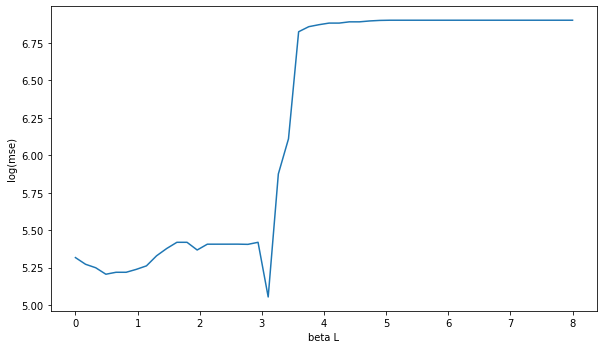

In [167]:
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)

ax.set_xlabel('beta L')
ax.set_ylabel('log(mse)')
ax.set_title('Estimation of optimal Beta L value')

ax.plot(beta_Ls, np.log(mses))

f.savefig